In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
img = cv2.imread("messi 1.webp")

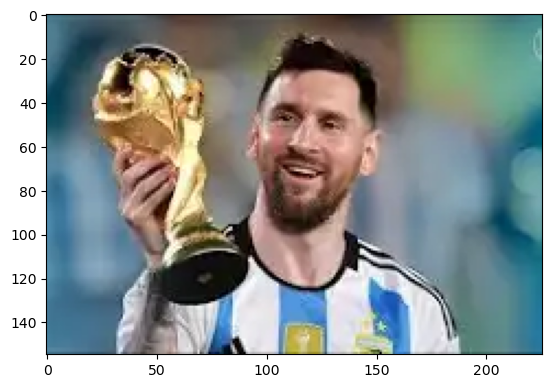

In [5]:
rgbImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgbImg)


In [7]:
grayImg = cv2.cvtColor(rgbImg,cv2.COLOR_RGB2GRAY)

In [9]:
edges = cv2.Canny(img,100,300)

Text(0.5, 1.0, 'Edge detected Image')

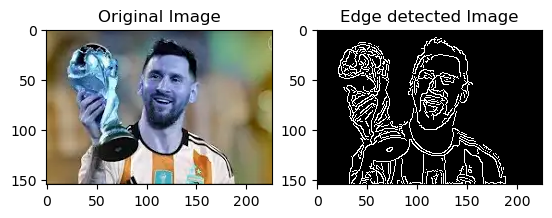

In [11]:
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(122)
plt.imshow(edges,cmap='gray')
plt.title("Edge detected Image")

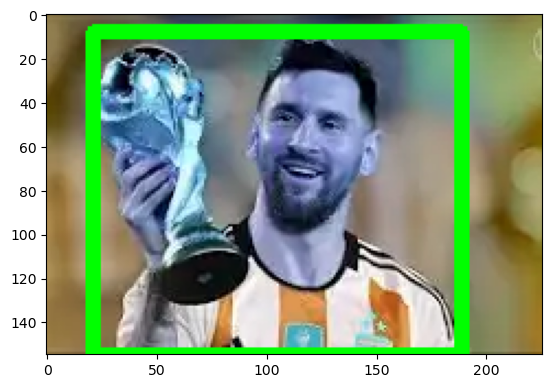

In [13]:

x,y,w,h = cv2.boundingRect(edges)
cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),5)
plt.imshow(img)

In [15]:
cropped_img = rgbImg[y:y+h,x:x+w]

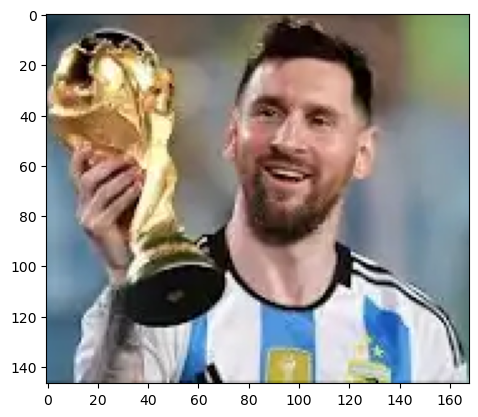

In [17]:
plt.imshow(cropped_img)

In [19]:
import tensorflow as tf

In [20]:
converted_img = tf.image.convert_image_dtype(cropped_img, tf.float32)
final_image = tf.image.resize(converted_img,(224,224))

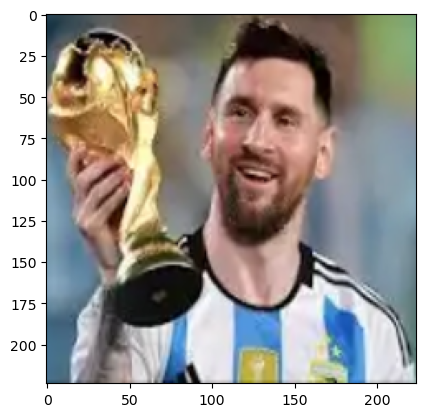

In [21]:
plt.imshow(final_image)

In [22]:
image_copy = final_image

# Converting to numpy array for reading in CV2 and into BGR mode

In [24]:
color = image_copy.numpy()*255

In [25]:
rgbProcessed = cv2.cvtColor(color,cv2.COLOR_BGR2RGB)

In [26]:
cv2.imwrite('messi_processed.jpg',rgbProcessed)

True

In [27]:
final = cv2.imread('messi_processed.jpg')

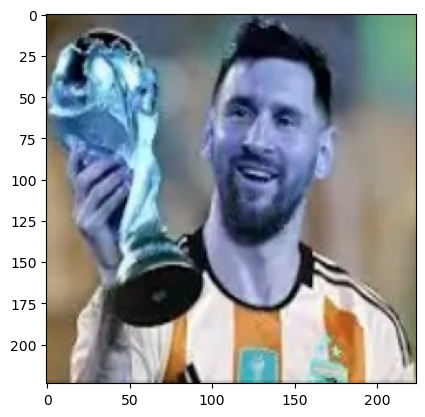

In [28]:
plt.imshow(final)

In [29]:
rgb_again = cv2.cvtColor(final,cv2.COLOR_BGR2RGB)

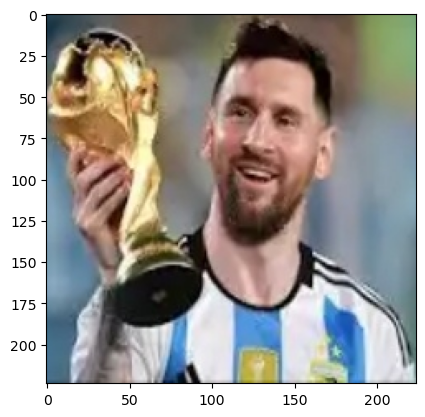

In [40]:

plt.imshow(rgb_again)

In [42]:
gray_image = cv2.cvtColor(rgb_again,cv2.COLOR_RGB2GRAY)

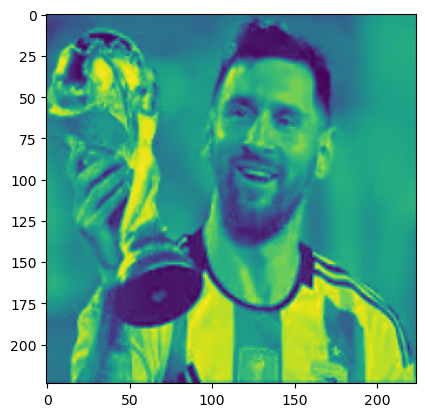

In [44]:
plt.imshow(gray_image)

In [46]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

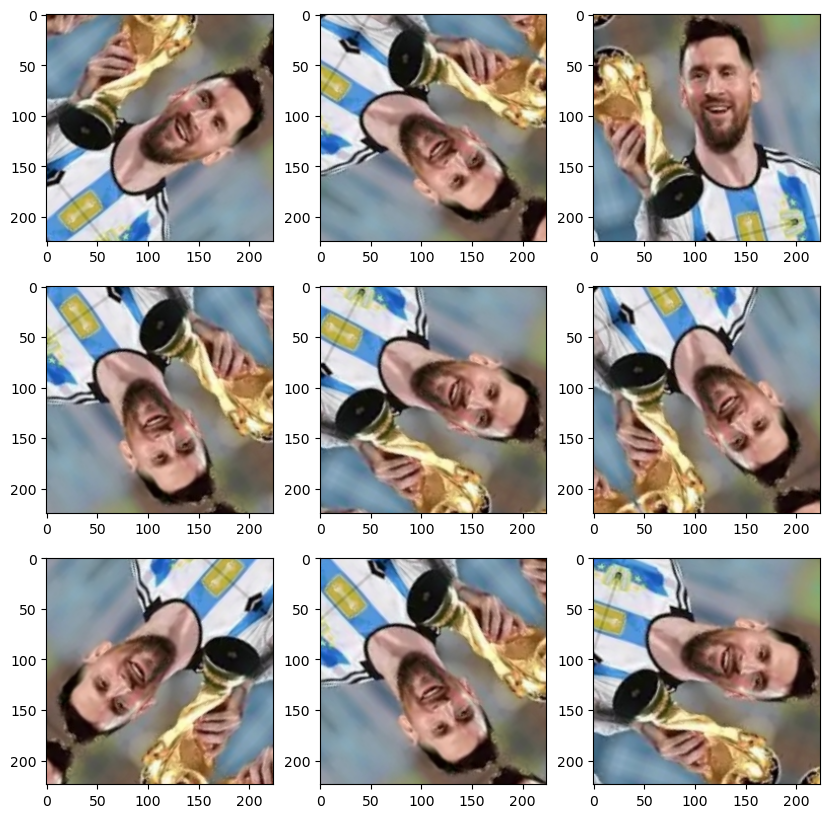

In [48]:
plt.figure(figsize=(10,10))
augmented_images = []
for i in range(9):
    augmented_img = data_augmentation(rgb_again/255)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_img)
    augmented_images.append(augmented_img)

In [49]:
kernel = np.ones((5,5),np.float32)/25

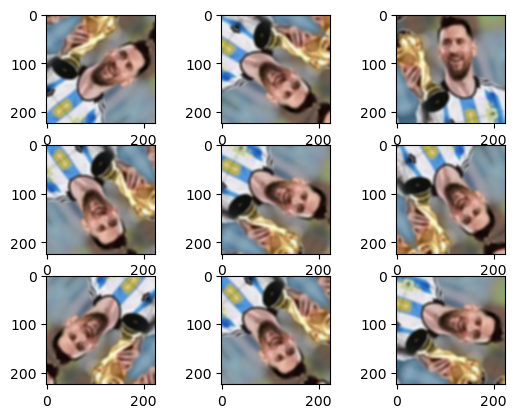

In [52]:
smoothened_images = []
for i in range(len(augmented_images)):
    #smoothened_img = cv2.filter2D(np.array(augmented_images[i]),-1,kernel)
    smoothened_img = cv2.bilateralFilter(np.array(augmented_images[i]),9,50,50)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(smoothened_img)
    smoothened_images.append(smoothened_img)

## As we move along the image detection part, we can use bilateral filter since it emphasizes more on the edge detection system

In [55]:
def add_salt_and_pepper_noise(image,noise_ratio=0.02):
    noise_img = image/255
    h,w,c = noise_img.shape
    noisy_pixels = int(h*w*noise_ratio)
    
    for _ in range(noisy_pixels):
        row, col = np.random.randint(0, h), np.random.randint(0, w)
        if np.random.rand() <= 0.5:
            noise_img[row][col] = [0,0,0]
        else:
            noise_img[row][col] = [255,255,255]
    return noise_img

In [57]:
noisy_image = add_salt_and_pepper_noise(rgb_again,noise_ratio=0.03)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


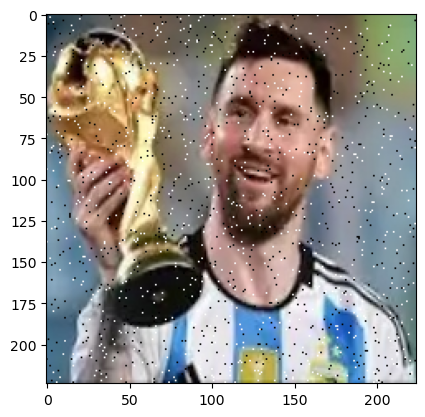

In [59]:
plt.imshow(noisy_image)

In [265]:
class ImageAugmentation:
    def __init__(self,images):
        self.images = images
        self.processed_images = self.batching_images()

    def detect_edge_and_clip(self,image):
        edges = cv2.Canny(image,100,300)
        x,y,w,h = cv2.boundingRect(edges)
        cropped_img = image[y:y+h,x:x+w]
        converted_img = tf.image.convert_image_dtype(cropped_img, tf.float32)
        final_image = tf.image.resize(converted_img,(224,224))
        return final_image
    
    def make_rot_scale(self,image):
        data_rotate_flip = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.2),
        ])
        rotated_images = []
        for i in range(10):
            augmented_image = data_rotate_flip(image/255)
            rotated_images.append(augmented_image)
        return rotated_images
    
    def color_grading(self,image):
        rgb_img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        return (rgb_img,gray_img)
    
    def add_noise(self,image,noise_ratio=0.02):
        noise_img = image/255.0
        h,w,c = noise_img.shape
        noisy_pixels = int(h*w*noise_ratio)

        for _ in range(noisy_pixels):
            row, col = np.random.randint(0, h), np.random.randint(0, w)
            if np.random.rand() <= 0.5:
                noise_img[row][col] = [0,0,0]
            else:
                noise_img[row][col] = [255,255,255]
        return noise_img
    
    def add_blur_smoothening(self,image):
        smoothened_img = cv2.bilateralFilter(np.array(image),9,50,50)
        return smoothened_img
    
    def augment_img(self,image):
        nrm_image = self.detect_edge_and_clip(image)
        nrm_noise = self.add_noise(nrm_image.numpy()*255)
        rot_scaled_nrm = self.make_rot_scale(nrm_image)
        rot_scaled_nrm_noise = self.make_rot_scale(nrm_noise)
        rgb_nrm = cv2.cvtColor(nrm_image.numpy()*255,cv2.COLOR_BGR2RGB)
        nrm_blur = self.add_blur_smoothening(rgb_nrm)
        nrm_noise_blur = self.add_blur_smoothening(nrm_noise)
        nrm_scaled_rot_blur_imgs = []
        for i in range(10):
            nrm_scaled_rot_blur = self.add_blur_smoothening(rot_scaled_nrm[i]*255)
            nrm_scaled_rot_blur_imgs.append(nrm_scaled_rot_blur)
        nrm_scaled_rot_noise_blur_imgs = []
        for i in range(len(rot_scaled_nrm_noise)):
            nrm_scaled_rot_noise_blur = self.add_blur_smoothening(rot_scaled_nrm_noise[i])
            nrm_scaled_rot_noise_blur_imgs.append(nrm_scaled_rot_noise_blur)
        
        return nrm_image,nrm_noise,nrm_blur,rot_scaled_nrm,nrm_scaled_rot_blur_imgs,nrm_scaled_rot_noise_blur_imgs,rot_scaled_nrm_noise,nrm_noise_blur

    def batching_images(self):
        for img in self.images:
            normal_img,normal_noise,normal_blur,normal_rotated,normal_rotated_blur,normal_rotated_noise_blur,normal_rotated_noise,normal_noise_blur = self.augment_img(img)
#             rgb_image, gray_image = self.color_grading(img)
#             rgb_img,rgb_noise,rgb_blur,rgb_rotated,rgb_rotated_blur,rgb__rotated_noise_blur,rgb_rotated_noise,rgb_noise_blur = self.augment_img(rgb_image)
#             gray_img,gray_noise,gray_blur,gray_rotated,gray_rotated_blur,gray__rotated_noise_blur,gray_rotated_noise,gray_noise_blur = self.augment_img(gray_image)

            processed_img = []
            bgr = [normal_img,normal_noise,normal_blur,normal_rotated,normal_rotated_blur,normal_rotated_noise_blur,normal_rotated_noise,normal_noise_blur]
#             rgb = [rgb_img,rgb_noise,rgb_blur,rgb_rotated,rgb_rotated_blur,rgb__rotated_noise_blur,rgb_rotated_noise,rgb_noise_blur]
#             gray = [gray_img,gray_noise,gray_blur,gray_rotated,gray_rotated_blur,gray__rotated_noise_blur,gray_rotated_noise,gray_noise_blur]

            processed_img.append(bgr)
#             processed_img.append(rgb)
#             processed_img.append(gray)

            return processed_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


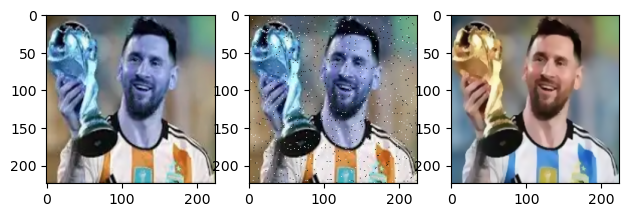

In [267]:
if __name__=="__main__":
    img = cv2.imread('messi 1.webp')
    image_augmentation = ImageAugmentation([img])
    final_image_set = image_augmentation.processed_images

    bgr_img_set = final_image_set[0]
#     rgb_img_set = final_image_set[1]
#     gray_img_set = final_image_set[2]

#     for i in bgr_img_set:
#         plt.imshow(i)
    #print(len(bgr_img_set))
    plt.figure(figsize=(10,10))
    for i in range(3):
        ax = plt.subplot(2,4,i+1)
        if i in [0,1]:
            plt.imshow(bgr_img_set[i])
        else:
            plt.imshow(bgr_img_set[i]/255)

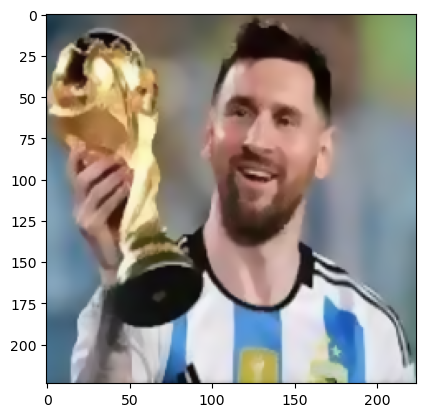

In [269]:
plt.imshow(bgr_img_set[2]/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


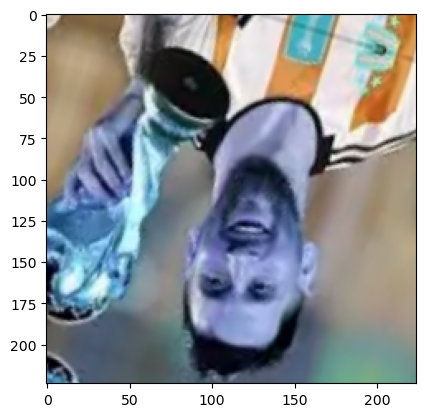

In [271]:
plt.imshow(bgr_img_set[3][1]*255)

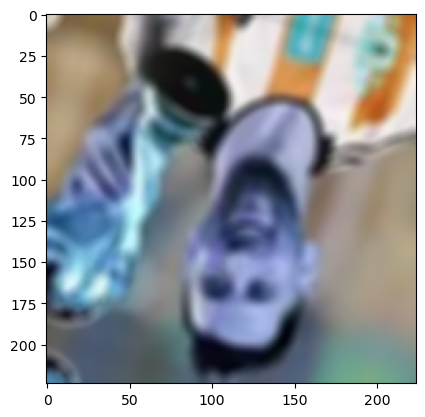

In [273]:
plt.imshow(bgr_img_set[4][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


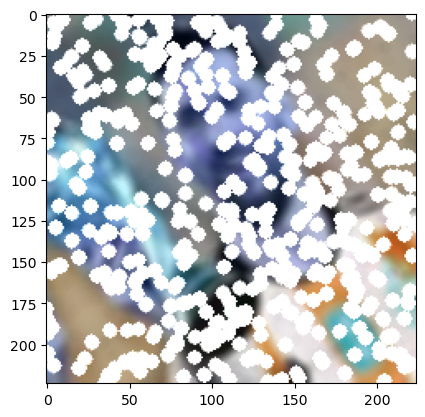

In [293]:
plt.imshow(bgr_img_set[5][0]*255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


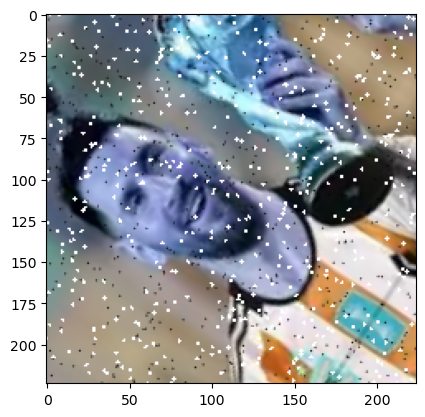

In [231]:
plt.imshow(bgr_img_set[6][3]*255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


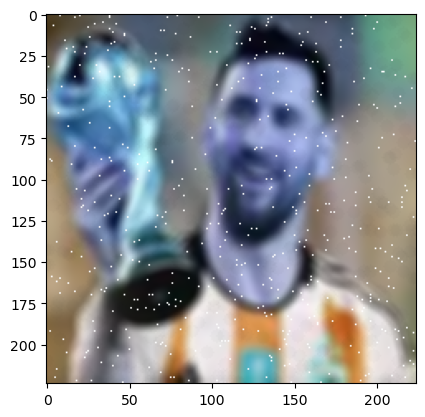

In [295]:
plt.imshow(bgr_img_set[7])

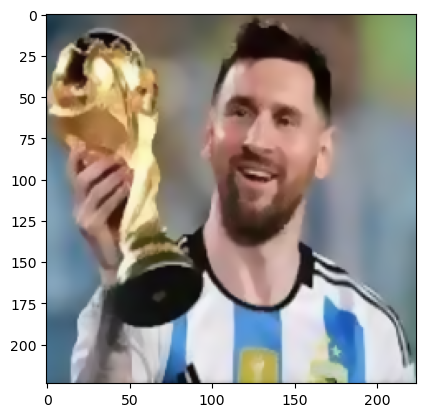

In [97]:
img = np.array(bgr_img_set[2][0])
plt.imshow(img/255)


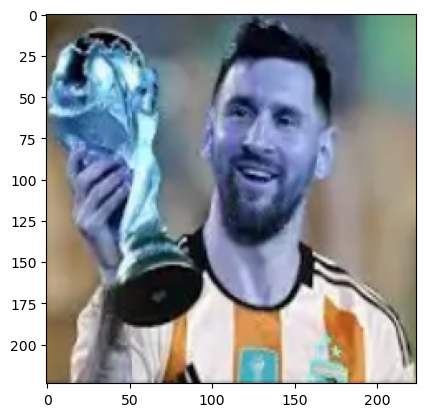

In [42]:
edges = cv2.Canny(img,100,300)
x,y,w,h = cv2.boundingRect(edges)
cropped_img = img[y:y+h,x:x+w]
converted_img = tf.image.convert_image_dtype(cropped_img, tf.float32)
final_image = tf.image.resize(converted_img,(224,224))
plt.imshow(final_image)

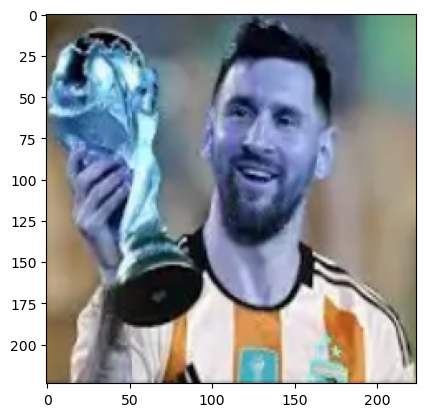

In [41]:
edges = cv2.Canny(img,100,300)
x,y,w,h = cv2.boundingRect(edges)
cropped_img = img[y:y+h,x:x+w]
converted_img = tf.image.convert_image_dtype(cropped_img, tf.float32)
final_image = tf.image.resize(converted_img,(224,224))
plt.imshow(final_image)

In [90]:
noise_img = add_salt_and_pepper_noise(final_image.numpy()*255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


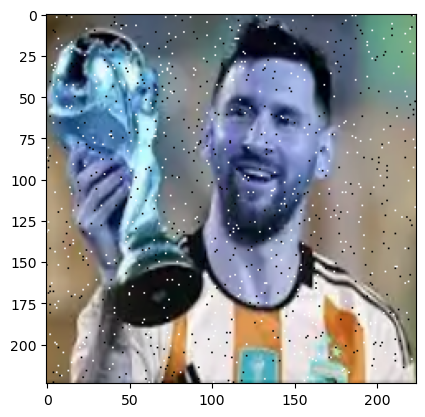

In [91]:
plt.imshow(noise_img)